# 0. Exploratory Data Analysis (EDA) for Snow Depth Prediction

In this EDA, we aim to understand the patterns and relationships in the historical weather and snow depth data for various ski resorts across the Alps. This analysis will guide us in selecting relevant features and building a robust model to predict snow depth, ultimately enhancing the service we provide to skiers.

We will follow an EDA plan, focusing on:

- Loading the Cleaned Data
- Analyzing Snow Depth Distribution Across Resorts
- Exploring Relationships Between Temperature and Snow Depth
- Assessing the Impact of Precipitation on Snow Depth
- Examining Seasonal Trends in Snow Depth
- Correlation Analysis Among Variables
- Additional Analyses as Needed

### 1(a). Loading the Cleaned Data
First, we'll load the cleaned and processed data into our environment for analysis.

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1 (b) Set Up the Data Directory

In [2]:
processed_data_root = '../data/processed/cds'

### 1 (c) Load DataFrames

We'll create a dictionary to hold DataFrames for each resort.

In [3]:
# Initialize an empty dictionary to store DataFrames
data_frames = {}

# Use glob to find all cleaned CSV files in the processed data directory
csv_files = glob.glob(os.path.join(processed_data_root, '**', '*_cleaned_*.csv'), recursive=True)

exclude_resorts = [
    'french_alps/chamonix',
    'french_alps/val_d_isere_tignes',
    'french_alps/les_trois_vallees',
    'swiss_alps/verbier'
]

for file_path in csv_files:
    # Extract country and resort from the file path
    parts = file_path.split(os.sep)
    country = parts[-3]
    resort = parts[-2]
    key = f"{country}/{resort}"

    if key in exclude_resorts:
        print(f"Excluding resort from EDA: {key}")
        continue  # Skip the excluded resorts
    
    # Load the DataFrame
    df = pd.read_csv(file_path)
    
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Store in the dictionary
    data_frames[key] = df
    print(f"Loaded data for {key}: {df.shape[0]} rows.")


Loaded data for austrian_alps/kitzbuhel: 11184 rows.
Loaded data for austrian_alps/solden: 12418 rows.
Loaded data for austrian_alps/st_anton: 12418 rows.
Excluding resort from EDA: french_alps/chamonix
Excluding resort from EDA: french_alps/les_trois_vallees
Excluding resort from EDA: french_alps/val_d_isere_tignes
Loaded data for italian_alps/cortina_d_ampezzo: 12015 rows.
Loaded data for italian_alps/sestriere: 12038 rows.
Loaded data for italian_alps/val_gardena: 12015 rows.
Loaded data for slovenian_alps/kranjska_gora: 12418 rows.
Loaded data for slovenian_alps/krvavec: 12418 rows.
Loaded data for slovenian_alps/mariborsko_pohorje: 12418 rows.
Loaded data for swiss_alps/st_moritz: 12009 rows.
Excluding resort from EDA: swiss_alps/verbier
Loaded data for swiss_alps/zermatt: 7943 rows.


### 1(d) Combine DataFrames for Analysis

We'll create a single DataFrame combining all resorts for certain analyses.

In [4]:
# Add 'resort' and 'country' columns to each DataFrame and combine them
combined_data = []

for key, df in data_frames.items():
    country, resort = key.split('/')
    df['resort'] = resort
    df['country'] = country
    combined_data.append(df)

# Concatenate all DataFrames
all_data = pd.concat(combined_data, ignore_index=True)

# Update the list of resorts
included_resorts = all_data['resort'].unique()
print(f"Included resorts: {included_resorts}")

Included resorts: ['kitzbuhel' 'solden' 'st_anton' 'cortina_d_ampezzo' 'sestriere'
 'val_gardena' 'kranjska_gora' 'krvavec' 'mariborsko_pohorje' 'st_moritz'
 'zermatt']


## 2. Snow Depth Distribution Across Resorts

Hypothesis

*** Snow depth varies significantly across different resorts and countries due to geographical and climatic differences. ***

### 2(a) Summary Statistics

In [5]:
# Group by resort and calculate summary statistics
snow_depth_stats = all_data.groupby('resort')['snow_depth'].describe()
snow_depth_stats

,count,mean,std,min,25%,50%,75%,max
resort,,,,,,,,
cortina_d_ampezzo,3203.0,259.398876,284.675849,0.0,61.0,170.0,351.0,1610.0
kitzbuhel,9351.0,129.728200,238.295453,0.0,0.0,0.0,180.0,1570.0
kranjska_gora,8894.0,177.204610,133.011877,0.0,70.0,155.0,264.5,700.0
krvavec,3704.0,52.052403,93.209564,0.0,0.0,0.0,71.0,1280.0
mariborsko_pohorje,5145.0,39.511273,88.598428,0.0,0.0,0.0,20.0,1199.0
sestriere,2931.0,37.459024,100.035408,0.0,0.0,0.0,20.0,1509.0
solden,4678.0,63.790637,108.644672,0.0,0.0,0.0,89.0,2111.0
st_anton,11363.0,74.908008,162.222275,0.0,0.0,0.0,70.0,1500.0
st_moritz,3653.0,180.569422,239.992289,0.0,10.0,79.0,249.0,2499.0


### 2(b) Box Plots

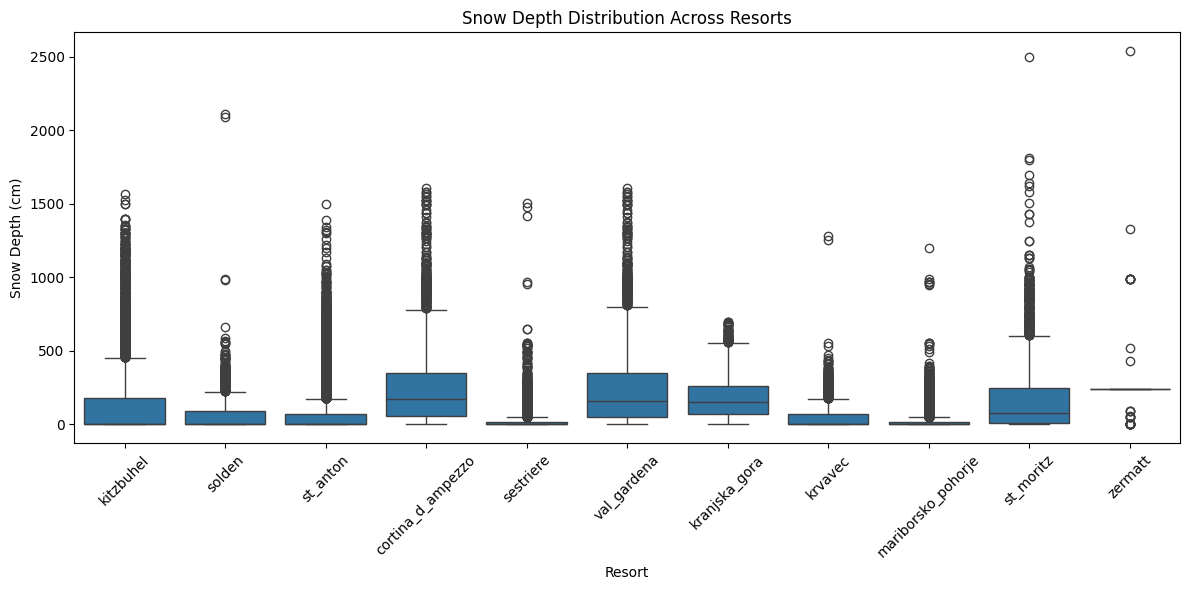

In [6]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create a box plot
sns.boxplot(x='resort', y='snow_depth', data=all_data)
plt.xticks(rotation=45)
plt.title('Snow Depth Distribution Across Resorts')
plt.ylabel('Snow Depth (cm)')
plt.xlabel('Resort')
plt.tight_layout()
plt.show()

### 2(c) Violin Plots

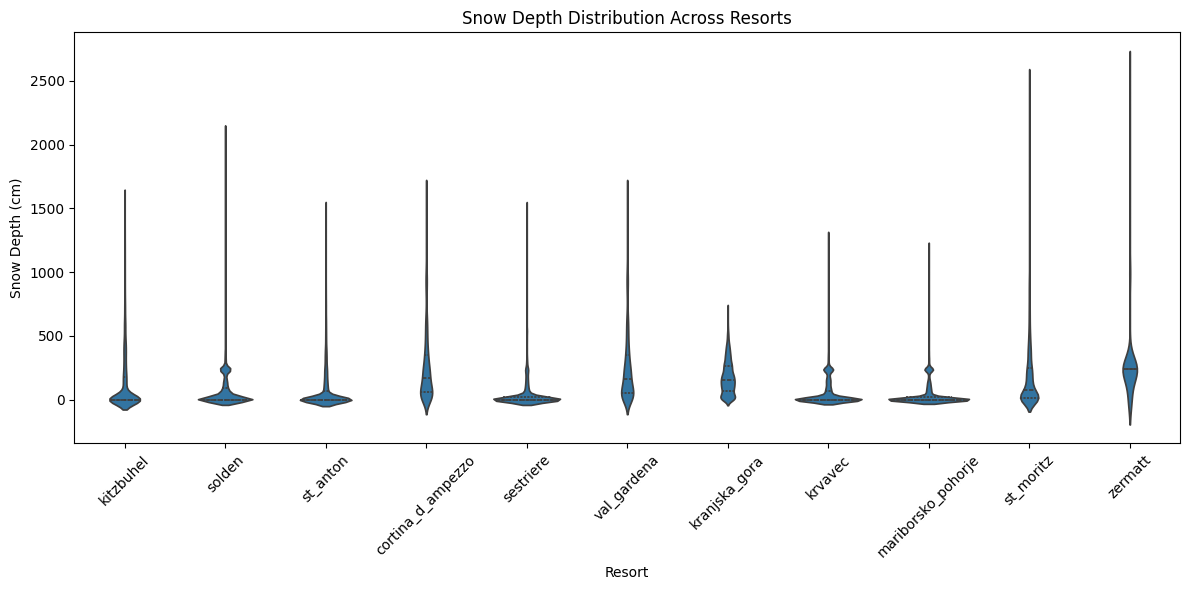

In [7]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create a violin plot
sns.violinplot(x='resort', y='snow_depth', data=all_data, inner='quartile')
plt.xticks(rotation=45)
plt.title('Snow Depth Distribution Across Resorts')
plt.ylabel('Snow Depth (cm)')
plt.xlabel('Resort')
plt.tight_layout()
plt.show()


## 3. Exploring Relationships Between Temperature and Snow Depth

Hypothesis:

Lower temperatures are associated with higher snow depths.
Understanding this relationship can help in predicting snow depth based on temperature forecasts.

### 3(a) Scatter Plots of Snow Depth vs. Temperature

Create scatter plots to visualize the relationship between snow depth and both minimum and maximum temperatures.